In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import pandas as pd
from tqdm import *
import matplotlib.pyplot as plt
device = "cuda:0"

In [14]:
train_df = pd.read_csv('../data/train.csv')
valid_df = pd.read_csv('../data/valid.csv')
test_df = pd.read_csv('../data/test.csv')

train_data = torch.tensor(train_df.to_numpy())
valid_data = torch.tensor(valid_df.to_numpy())
test_data = torch.tensor(test_df.to_numpy())

'''获取标签'''
train_y = train_data[:,0]
valid_y = valid_data[:,0]
test_y = test_data[:,0]

'''获取特征'''
train_x = train_data[:, 1:]
valid_x = valid_data[:, 1:]
test_x = test_data[:, 1:]

In [15]:
class CNN(nn.Module):
    def __init__(self, input_dim=21):
        super(CNN, self).__init__()
        self.input_dim = input_dim
        self.kernel_size_conv = 3
        self.stride_conv = 1
        self.kernel_size_pool = 2
        self.stride_pool = 2
        out_conv1 = (input_dim - self.kernel_size_conv) // self.stride_conv + 1
        out_pool1 = (out_conv1 - self.kernel_size_pool) // self.stride_pool + 1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=self.kernel_size_conv)
        self.pool = nn.MaxPool1d(kernel_size=self.kernel_size_pool, stride=self.stride_pool)
        self.fc1 = nn.Linear(in_features=128*out_pool1, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=2)

    def forward(self, x):
        x = x.view(-1, 1, self.input_dim)
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
def train(dataloader, model, optimizer, loss_func, epochs, device):
    model = model.to(device)
    model.train()

    losses = []
    for epoch in tqdm(range(epochs)):
        loss = 0 
        for idx, data in enumerate(dataloader):
            x = data[0].to(device).float()
            y = data[1].to(device).long()
            #print(x.shape)

            optimizer.zero_grad()
            probs = model(x).float()
            #print(probs.shape)
            l = loss_func(probs, y)
            l.backward()
            loss+=l.item()
            optimizer.step()
        losses.append(loss)
        
    plt.figure()
    plt.plot(losses)

    return losses[-1]

In [17]:
'''指标计算'''
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

def eval(dataloader, model, device):
    model.eval()
    probs = torch.tensor([]).to(device)
    true_labels = torch.tensor([]).to(device)
    with torch.no_grad():
        for idx, data in tqdm(enumerate(dataloader)):
            x = data[0].to(device).float()
            true_labels = torch.cat([true_labels, data[1].to(device)], dim=0)
            prob = model(x).squeeze()
            
            probs = torch.cat([probs, prob], dim=0)

        # 对多标签问题进行二进制分类处理
        predicted_labels = torch.argmax(probs, dim=1)

        accuracy = balanced_accuracy_score(true_labels.cpu().numpy(), predicted_labels.cpu().numpy())
        recall = recall_score(true_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='macro')
        precision = precision_score(true_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='macro')
        f1 = f1_score(true_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='macro')
        auc = roc_auc_score(true_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='macro')

        print("模型精度为：{:.4f}".format(accuracy))
        print("模型召回率为：{:.4f}".format(recall))
        print("模型精确率为：{:.4f}".format(precision))
        print("模型F1分数为：{:.4f}".format(f1))
        print("模型AUC值为：{:.4f}".format(auc))

    model.train()

    return predicted_labels

In [18]:
'''准备数据集'''
train_dataset = TensorDataset(train_x, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=False)

valid_dataset = TensorDataset(valid_x, valid_y)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=True, drop_last=False)

test_dataset = TensorDataset(test_x, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last=False)

In [19]:
loss_fuc = nn.CrossEntropyLoss()
model = CNN(len(train_df.columns)-1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


237.79918751120567

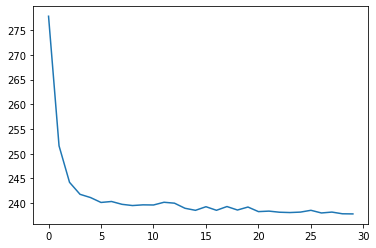

In [20]:
train(train_dataloader, model, optimizer, loss_fuc, 30, device)

In [21]:
print("训练集合指标：")
a=eval(train_dataloader, model, "cuda:0")
print("验证集合指标：")
b=eval(valid_dataloader, model, "cuda:0")
print("测试集合指标：")
c=eval(test_dataloader, model, "cuda:0")

训练集合指标：


442it [00:00, 923.61it/s]


模型精度为：0.7271
模型召回率为：0.7271
模型精确率为：0.7296
模型F1分数为：0.7281
模型AUC值为：0.7271
验证集合指标：


56it [00:00, 631.65it/s]


模型精度为：0.7244
模型召回率为：0.7244
模型精确率为：0.7269
模型F1分数为：0.7253
模型AUC值为：0.7244
测试集合指标：


56it [00:00, 880.68it/s]


模型精度为：0.7213
模型召回率为：0.7213
模型精确率为：0.7247
模型F1分数为：0.7226
模型AUC值为：0.7213
